<img src="../img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb - Freely Accessible ICU Database

version 1.0.2 March 2020  
Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

# <a id='numericitems'></a>numericitems table
The *numericitems* table contains all numerical measurements and observations, including vital parameters, data from medical devices, lab results, outputs from drains and foley-catheters, scores etc. All items have an associated admissionid from the [admissions](admissions.ipynb#admissions) table.

## Fields

|Name|Type|Description|
|:---|:---|:---|
|[admissionid](#admissionid)|integer|links the items with the admissionid in the [admissions](admissions.ipynb#admissions) table|
|[itemid](#itemid)|integer|id to identify the type of observation
|[item](#item)|string| name of the observation
|[tag](#tag)|string|used in some lab results to modify a value (e.g tag = '<' and value = 0.05, to demonstrate that a value is lower than the displayed value).
|unitid|integer|id of the unit of the observation. 
|unit|string|unit of the observation (e.g. mmHg). 
|[comment](#comment)|string|user specified comment. Comments may have been removed ('Opmerking verwijderd') due to containing personal data.
|[value](#value)|float|value of the observation
|measuredat|integer|time associated with this observation, expressed as milliseconds since the first ICU admission. Negative values imply that the observation (e.g. lab result) was performed before the first ICU admission
|registeredat|integer|time the result was stored in the database, expressed as milliseconds since the first admission. Negative values imply that the observation (e.g. lab result) was performed before the first ICU admission. For (automatic) lab results this value is the same as *measuredat* are the same.
|registeredby|string|the user group that entered the result, e.g. nurses, physicians or NULL for linked devices
|updatedat|integer|time the observation was updated in milliseconds from the first ICU admission.
|updatedby|string|the user group that entered the observation, e.g. nurses, physicians or NULL for linked devices
|[islabresult](#islabresult)|bit|determines whether the observation is a lab result (islabresult=1).
|[fluidout](#fluidout)|integer|the amount of fluid in ml that was removed from the patient (e.g. urine, drain).

# Example Python and SQL scripts

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

import io
from IPython.display import display, HTML, Markdown

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 288
plt.rcParams["figure.figsize"] = [8, 6]
plt.rcParams["font.size"] = 12

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Overview of all fields

In [4]:
sql = """
SELECT * FROM numericitems
LIMIT 10
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT * FROM numericitems
LIMIT 10

```

,admissionid,itemid,item,tag,value,unitid,unit,comment,measuredat,registeredat,registeredby,updatedat,updatedby,islabresult,fluidout
0,0,6640,Hartfrequentie,,73.0,15,/min,Opmerking verwijderd,33120000,33300000,ICV_IC-Verpleegkundig,33300000,ICV_IC-Verpleegkundig,0,None
1,0,6640,Hartfrequentie,,77.0,15,/min,Opmerking verwijderd,36720000,36960000,ICV_IC-Verpleegkundig,36960000,ICV_IC-Verpleegkundig,0,None
2,0,6640,Hartfrequentie,,77.0,15,/min,Opmerking verwijderd,87120000,87780000,ICV_IC-Verpleegkundig,87780000,ICV_IC-Verpleegkundig,0,None
3,0,6640,Hartfrequentie,,78.0,15,/min,Opmerking verwijderd,29520000,29460000,ICV_IC-Verpleegkundig,29469867,ICV_IC-Verpleegkundig,0,None
4,0,6640,Hartfrequentie,,78.0,15,/min,Opmerking verwijderd,40320000,40440000,ICV_IC-Verpleegkundig,40440000,ICV_IC-Verpleegkundig,0,None
5,0,6640,Hartfrequentie,,78.0,15,/min,Opmerking verwijderd,90720000,90840000,ICV_IC-Verpleegkundig,90840000,ICV_IC-Verpleegkundig,0,None
6,0,6640,Hartfrequentie,,79.0,15,/min,Opmerking verwijderd,43920000,45540000,ICV_IC-Verpleegkundig,45540000,ICV_IC-Verpleegkundig,0,None
7,0,6640,Hartfrequentie,,79.0,15,/min,Opmerking verwijderd,144720000,144720000,ICV_IC-Verpleegkundig,144720000,ICV_IC-Verpleegkundig,0,None
8,0,6640,Hartfrequentie,,82.0,15,/min,Opmerking verwijderd,25920000,26160000,ICV_IC-Verpleegkundig,26160000,ICV_IC-Verpleegkundig,0,None
9,0,6640,Hartfrequentie,,83.0,15,/min,Opmerking verwijderd,20520000,20580000,ICV_IC-Verpleegkundig,20580000,ICV_IC-Verpleegkundig,0,None


In [5]:
sql = """
SELECT COUNT(itemid) AS "Number of unique observations" FROM (
    SELECT DISTINCT admissionid, itemid, measuredat
    FROM numericitems
    ) as unique_items_table
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT COUNT(itemid) AS "Number of unique observations" FROM (
    SELECT DISTINCT admissionid, itemid, measuredat
    FROM numericitems
    ) as unique_items_table

```

,Number of unique observations
0,977394629


In [6]:
sql = """
SELECT COUNT(itemid) AS "Number of observations" 
FROM numericitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT COUNT(itemid) AS "Number of observations" 
FROM numericitems

```

,Number of observations
0,977625612


In [7]:
sql = """
SELECT *
FROM numericitems t1
JOIN (
    SELECT admissionid, itemid, measuredat
    FROM numericitems
    GROUP BY admissionid, itemid, measuredat
    HAVING COUNT(*) > 1
    ) t2 
ON t1.admissionid = t2.admissionid AND t1.itemid = t2.itemid AND t1.measuredat = t2.measuredat
ORDER BY t1.admissionid, t1.itemid, t1.measuredat
LIMIT 10
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT *
FROM numericitems t1
JOIN (
    SELECT admissionid, itemid, measuredat
    FROM numericitems
    GROUP BY admissionid, itemid, measuredat
    HAVING COUNT(*) > 1
    ) t2 
ON t1.admissionid = t2.admissionid AND t1.itemid = t2.itemid AND t1.measuredat = t2.measuredat
ORDER BY t1.admissionid, t1.itemid, t1.measuredat
LIMIT 10

```

,admissionid,itemid,item,tag,value,unitid,unit,comment,measuredat,registeredat,registeredby,updatedat,updatedby,islabresult,fluidout,admissionid,itemid,measuredat
0,4,9469,Pacemaker Frequentie,,30.0,0,None,None,157680000,164250000,ICV_MC-Verpleegkundig,164250000,ICV_MC-Verpleegkundig,0,None,4,9469,157680000
1,4,9469,Pacemaker Frequentie,,30.0,0,None,Opmerking verwijderd,157680000,164220000,ICV_MC-Verpleegkundig,164250740,ICV_MC-Verpleegkundig,0,None,4,9469,157680000
2,4,9470,Pacemaker Ventricle ampl.(output) ingesteld,,4.0,0,None,None,157680000,164250000,ICV_MC-Verpleegkundig,164250000,ICV_MC-Verpleegkundig,0,None,4,9470,157680000
3,4,9470,Pacemaker Ventricle ampl.(output) ingesteld,,4.0,0,None,Opmerking verwijderd,157680000,164220000,ICV_MC-Verpleegkundig,164250744,ICV_MC-Verpleegkundig,0,None,4,9470,157680000
4,4,9471,Pacemaker Ventricle sense ingesteld,,2.0,150,mV,None,157680000,164250000,ICV_MC-Verpleegkundig,164250000,ICV_MC-Verpleegkundig,0,None,4,9471,157680000
5,4,9471,Pacemaker Ventricle sense ingesteld,,2.0,150,mV,Opmerking verwijderd,157680000,164220000,ICV_MC-Verpleegkundig,164250744,ICV_MC-Verpleegkundig,0,None,4,9471,157680000
6,4,19363,Pacemaker Ventricle ampl.(output) gemeten,,2.0,0,None,None,157680000,164250000,ICV_MC-Verpleegkundig,164250000,ICV_MC-Verpleegkundig,0,None,4,19363,157680000
7,4,19363,Pacemaker Ventricle ampl.(output) gemeten,,2.0,0,None,Opmerking verwijderd,157680000,164220000,ICV_MC-Verpleegkundig,164250744,ICV_MC-Verpleegkundig,0,None,4,19363,157680000
8,4,19609,BPS score,,3.0,191,Geen,None,6900000,7119000,ICV_IC-Verpleegkundig,7119000,ICV_IC-Verpleegkundig,0,None,4,19609,6900000
9,4,19609,BPS score,,3.0,191,Geen,Opmerking verwijderd,6900000,7080000,ICV_IC-Verpleegkundig,7119626,ICV_IC-Verpleegkundig,0,None,4,19609,6900000


## <a id='item'></a>item / <a id='itemid'></a>itemid
Name of the observation, such as heart rate, saturation, arterial blood pressure, labs...

In [8]:
sql = """
SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM numericitems
GROUP BY item, itemid
ORDER BY "number of observations" DESC
"""
import matplotlib as mpl
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df.head(10)

``` mysql

SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM numericitems
GROUP BY item, itemid
ORDER BY "number of observations" DESC

```

,item,number of observations,itemid
0,Hartfrequentie,37732398,6640
1,Saturatie (Monitor),36411768,6709
2,ABP gemiddeld,33352770,6642
3,ABP systolisch,33343613,6641
4,ABP diastolisch,33343274,6643
5,ST segment analyse afleiding II,29972870,6665
6,ST segment analyse afleiding,29124627,6666
7,ST segment analyse afleiding I,28316202,6664
8,Ademfrequentie Monitor,25776086,8874
9,ST segment analyse afleiding AVR,24277363,6667


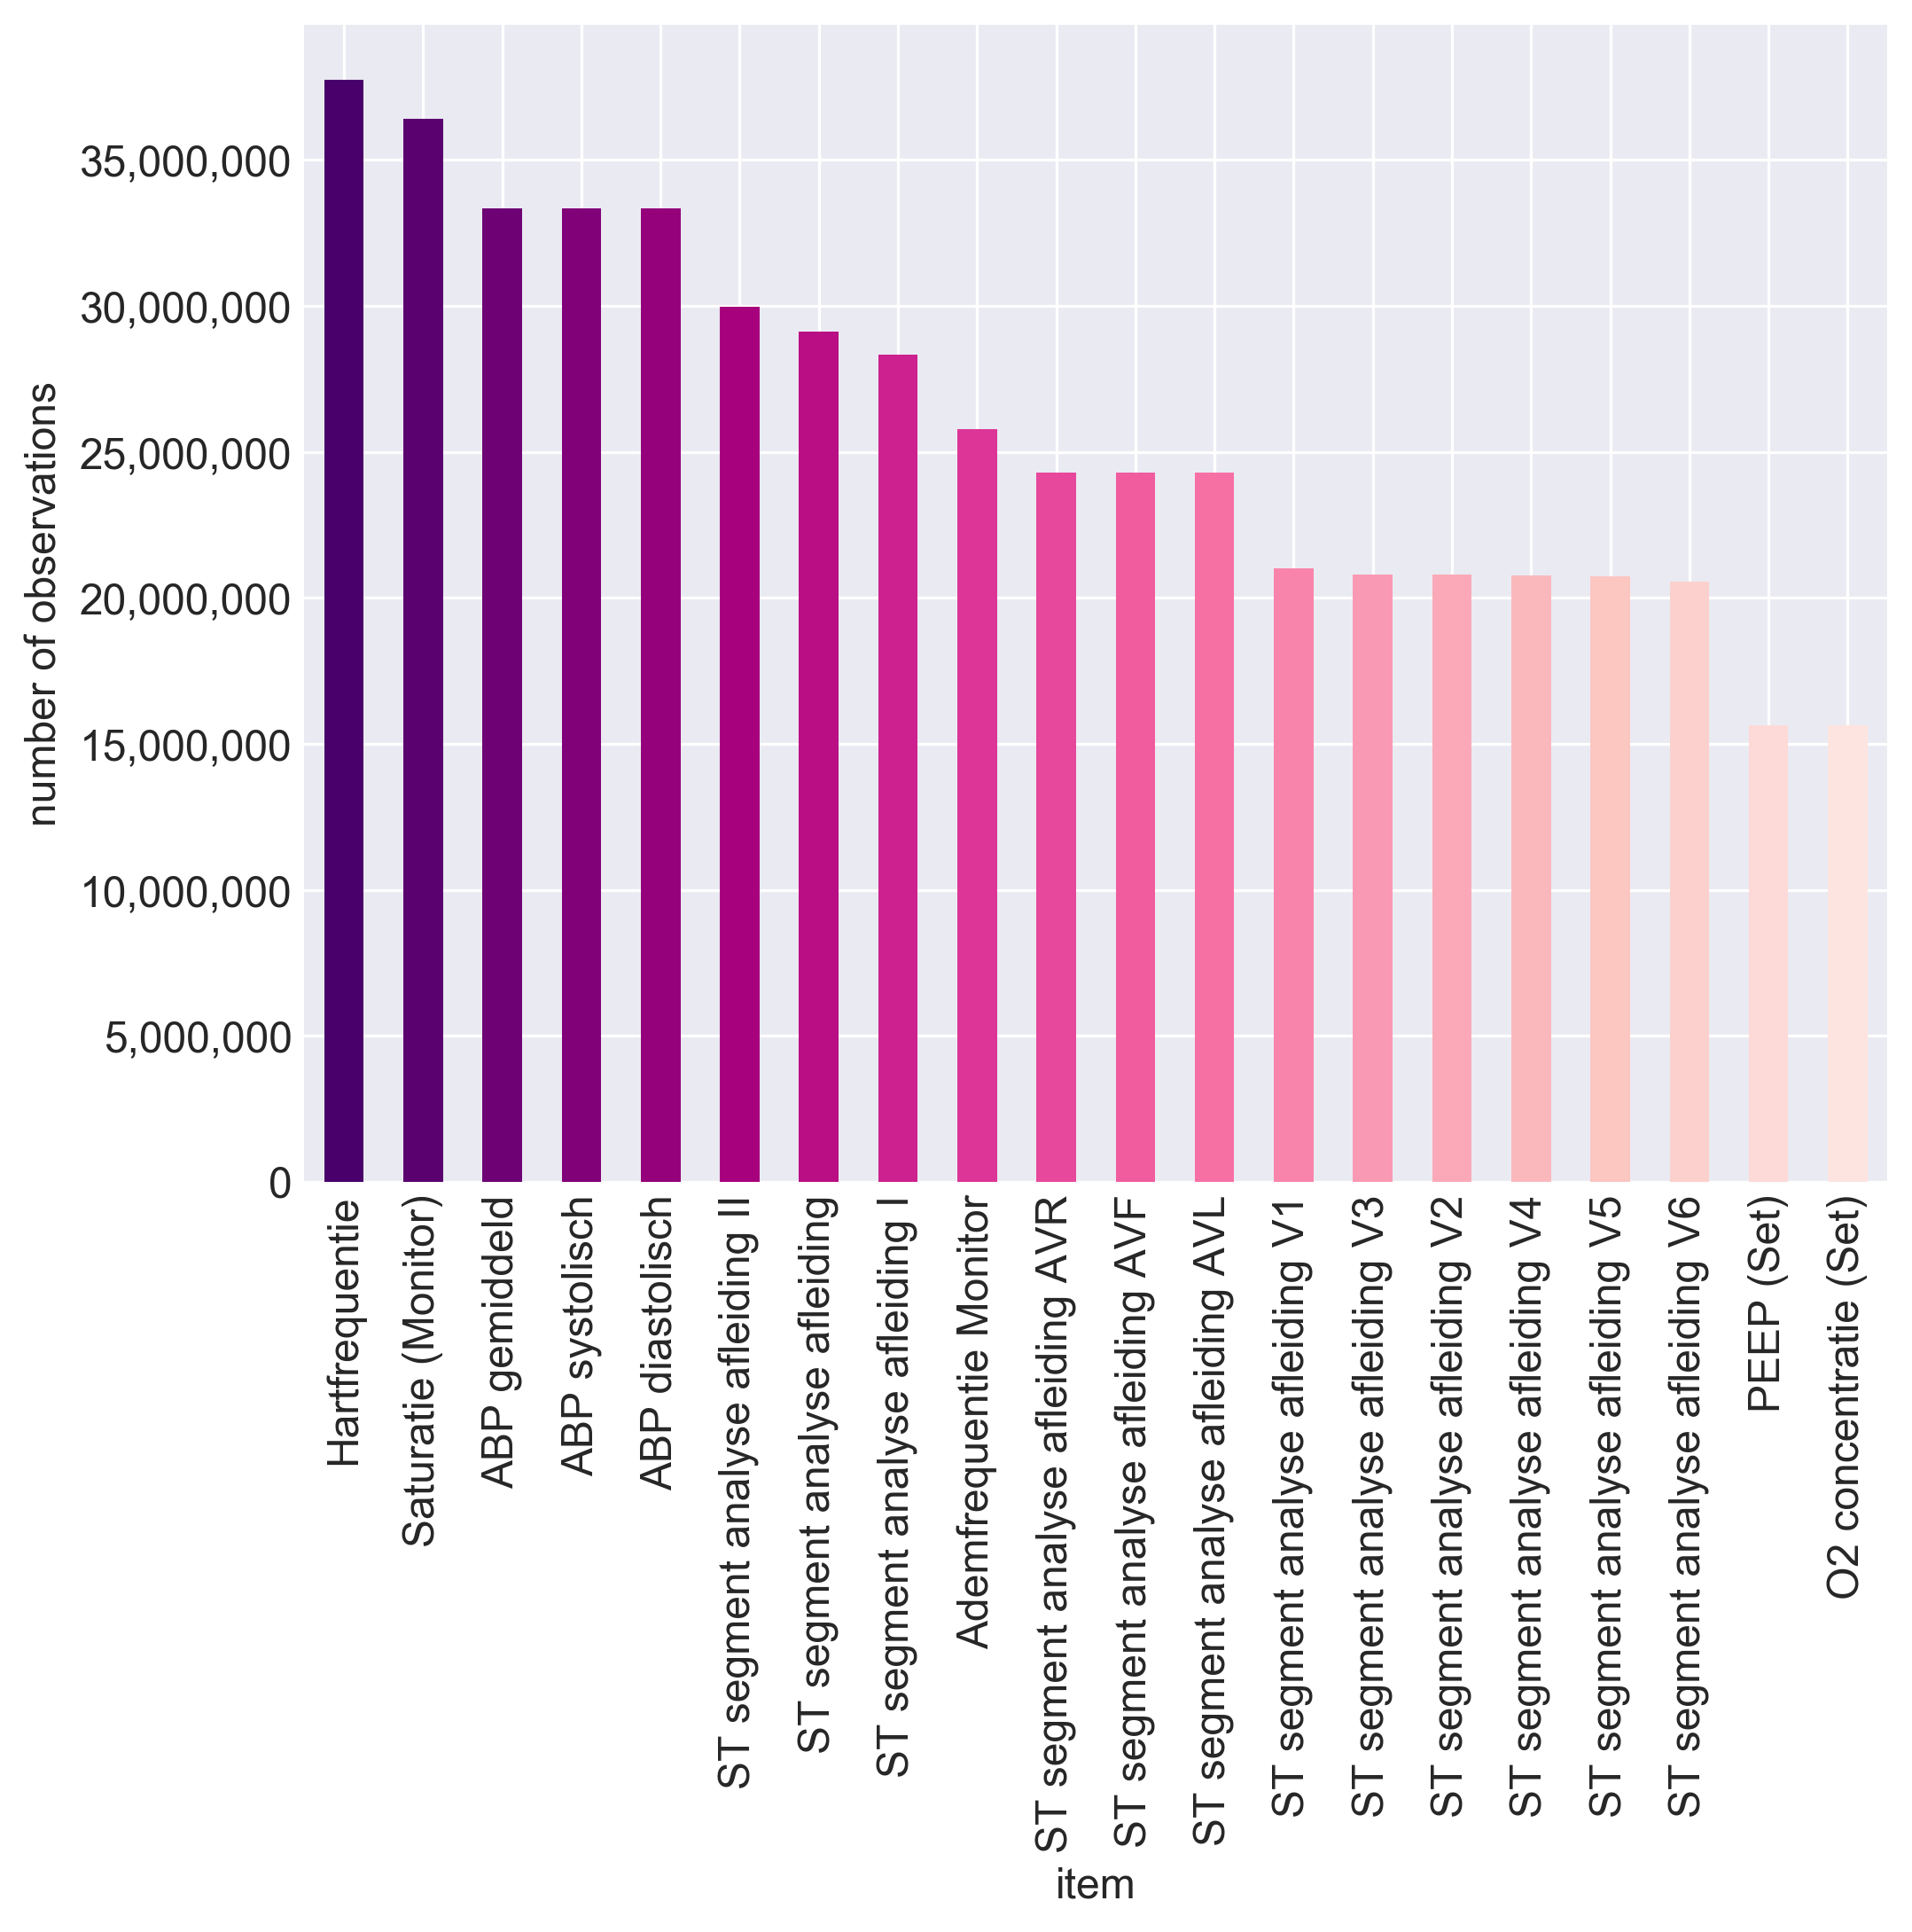

In [9]:
data = df.head(20)
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(data.index))
ax = data.plot.bar(x=data.columns[0],y=data.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=data.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## <a id='admissionid'></a>admissionid
### Items by year group
Device data, measurements and settings from the patient monitor, mechanical ventilator, hemofiltration device and so on, were automatically captured and stored in the database every minute. Every nurse was required to validate these data at least hourly on the ICU and two-hourly on the MCU, and important changes had to be validated or documented as well. Initially only  validated data and hourly data were stored for archival purposes, but due to advancements in hard disk storage, it was decided to archive all data.

In [10]:
sql = """
SELECT  admissionyeargroup, COUNT(itemid) AS "number of observations", item, itemid
FROM numericitems
LEFT JOIN admissions on numericitems.admissionid = admissions.admissionid
WHERE itemid = 6640 --heart rate
GROUP BY admissionyeargroup, item, itemid
ORDER BY admissionyeargroup ASC
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT  admissionyeargroup, COUNT(itemid) AS "number of observations", item, itemid
FROM numericitems
LEFT JOIN admissions on numericitems.admissionid = admissions.admissionid
WHERE itemid = 6640 --heart rate
GROUP BY admissionyeargroup, item, itemid
ORDER BY admissionyeargroup ASC

```

,admissionyeargroup,number of observations,item,itemid
0,2003-2009,2067349,Hartfrequentie,6640
1,2010-2016,35665049,Hartfrequentie,6640


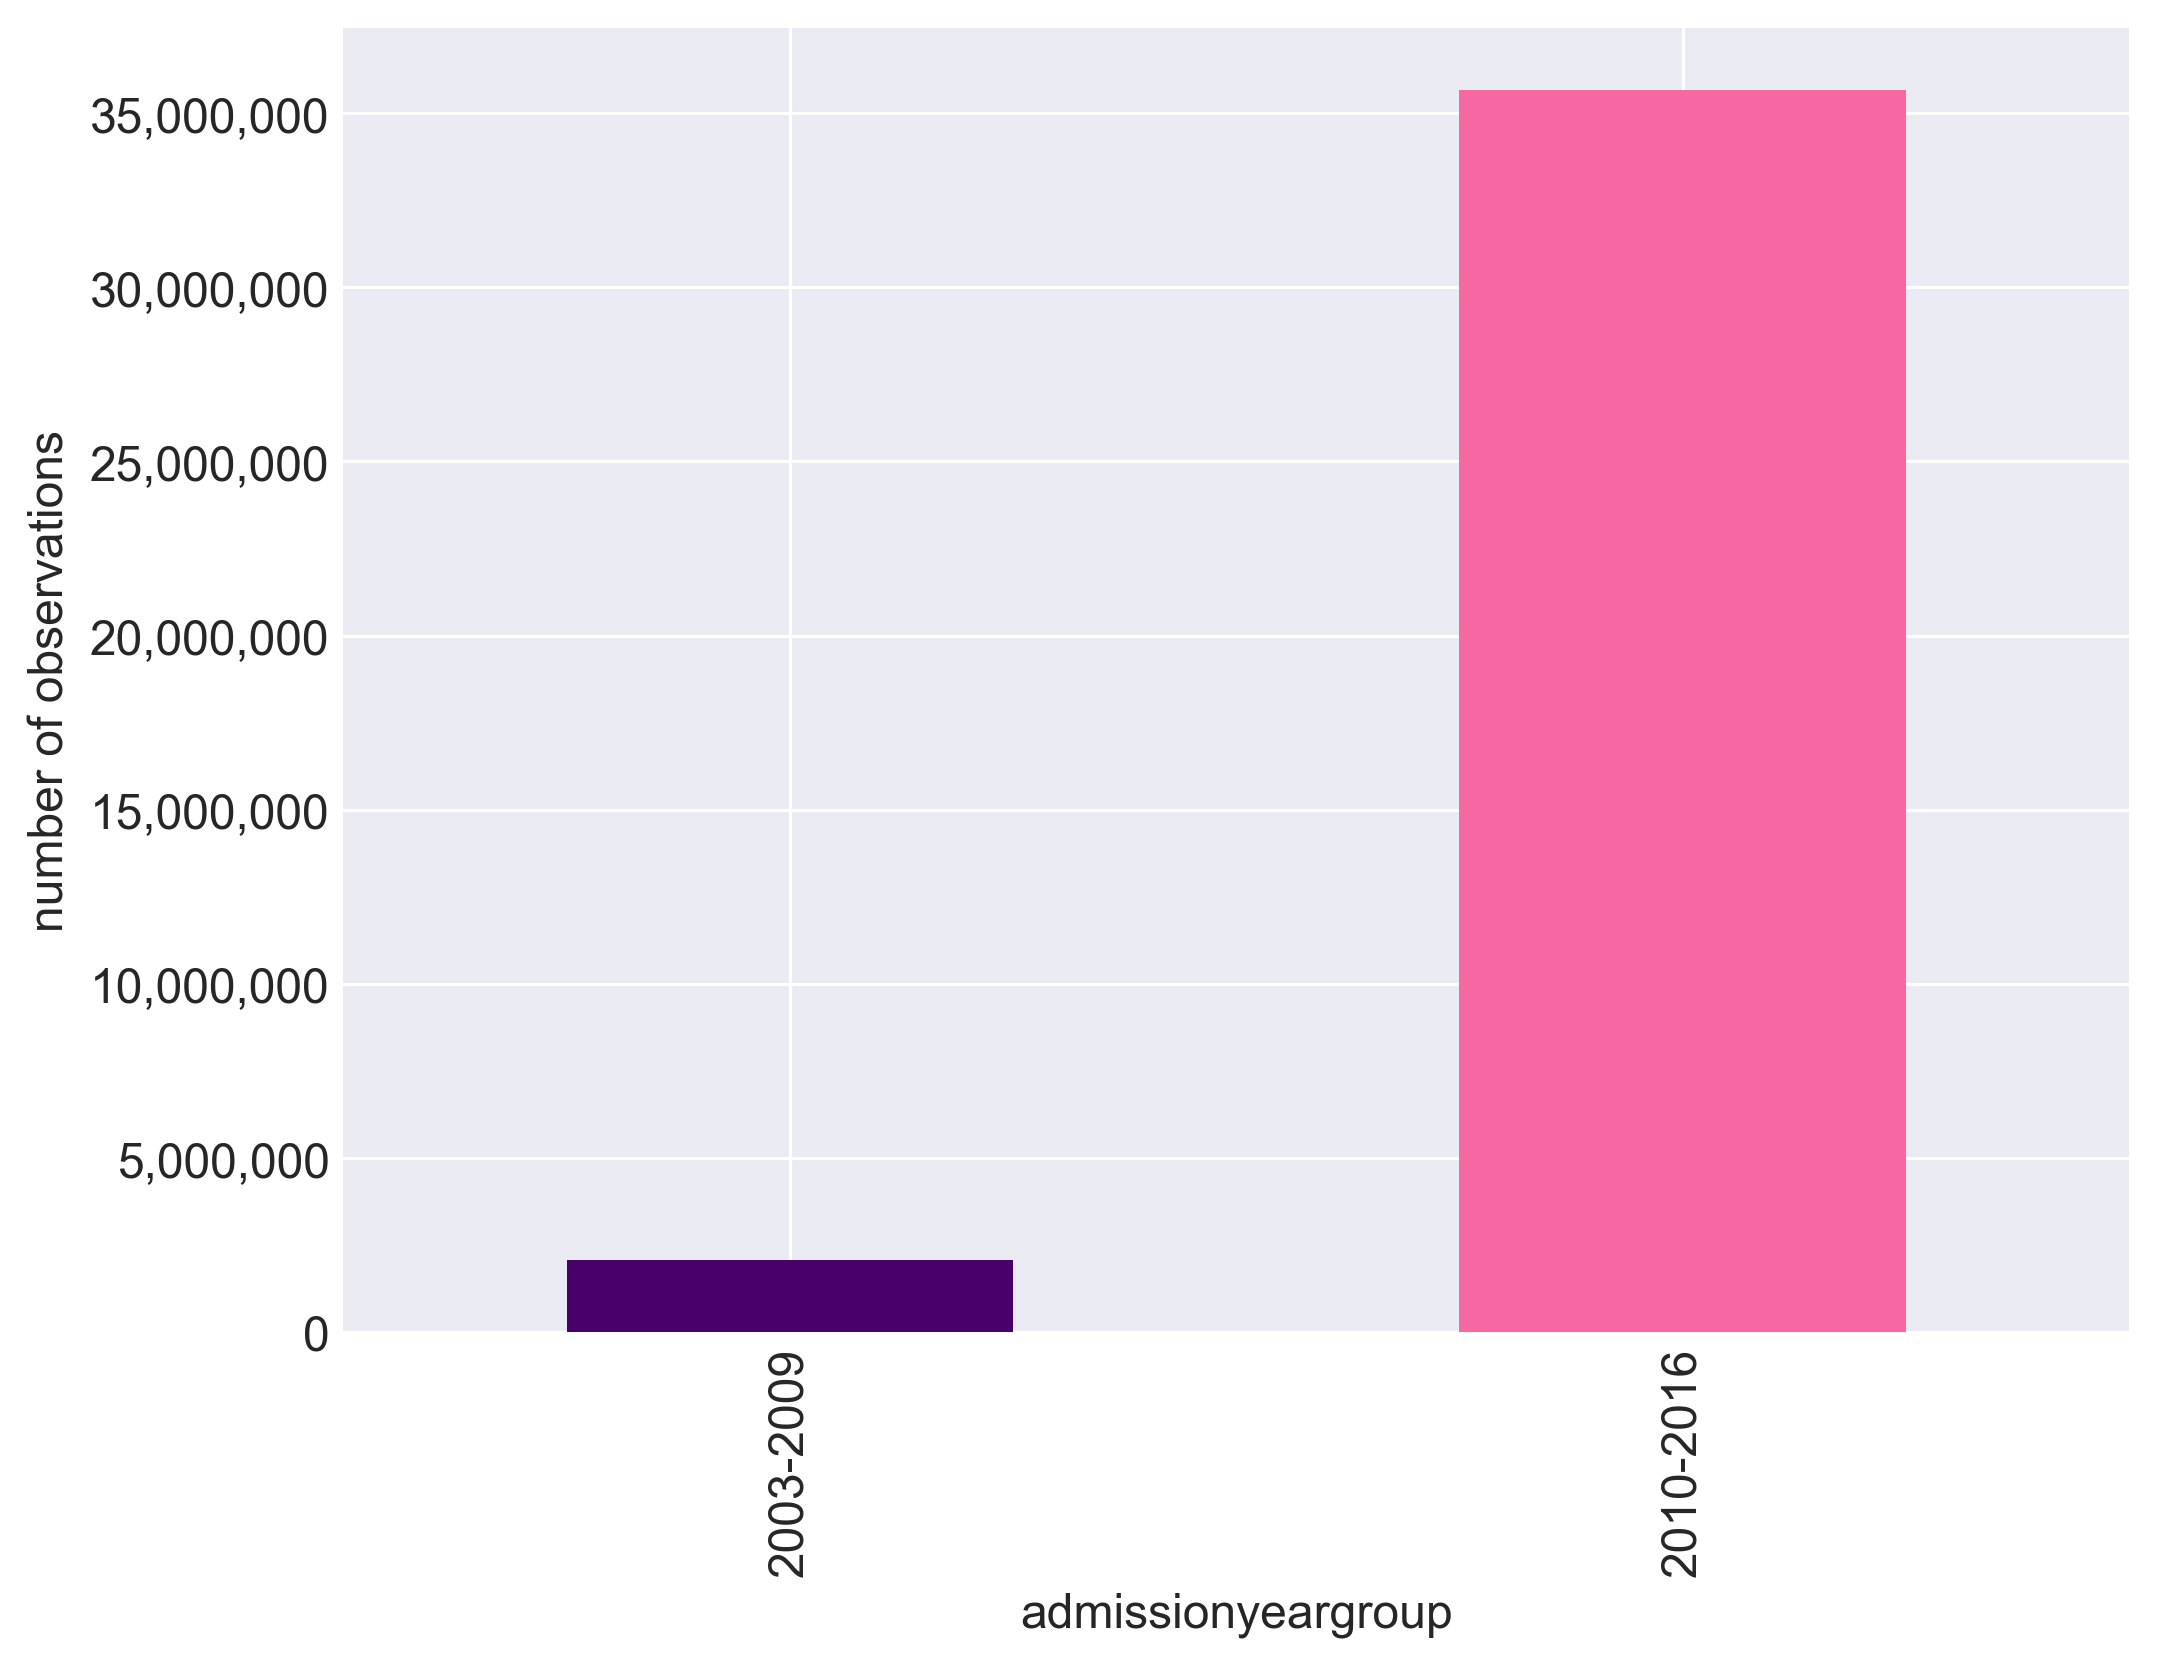

In [11]:
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

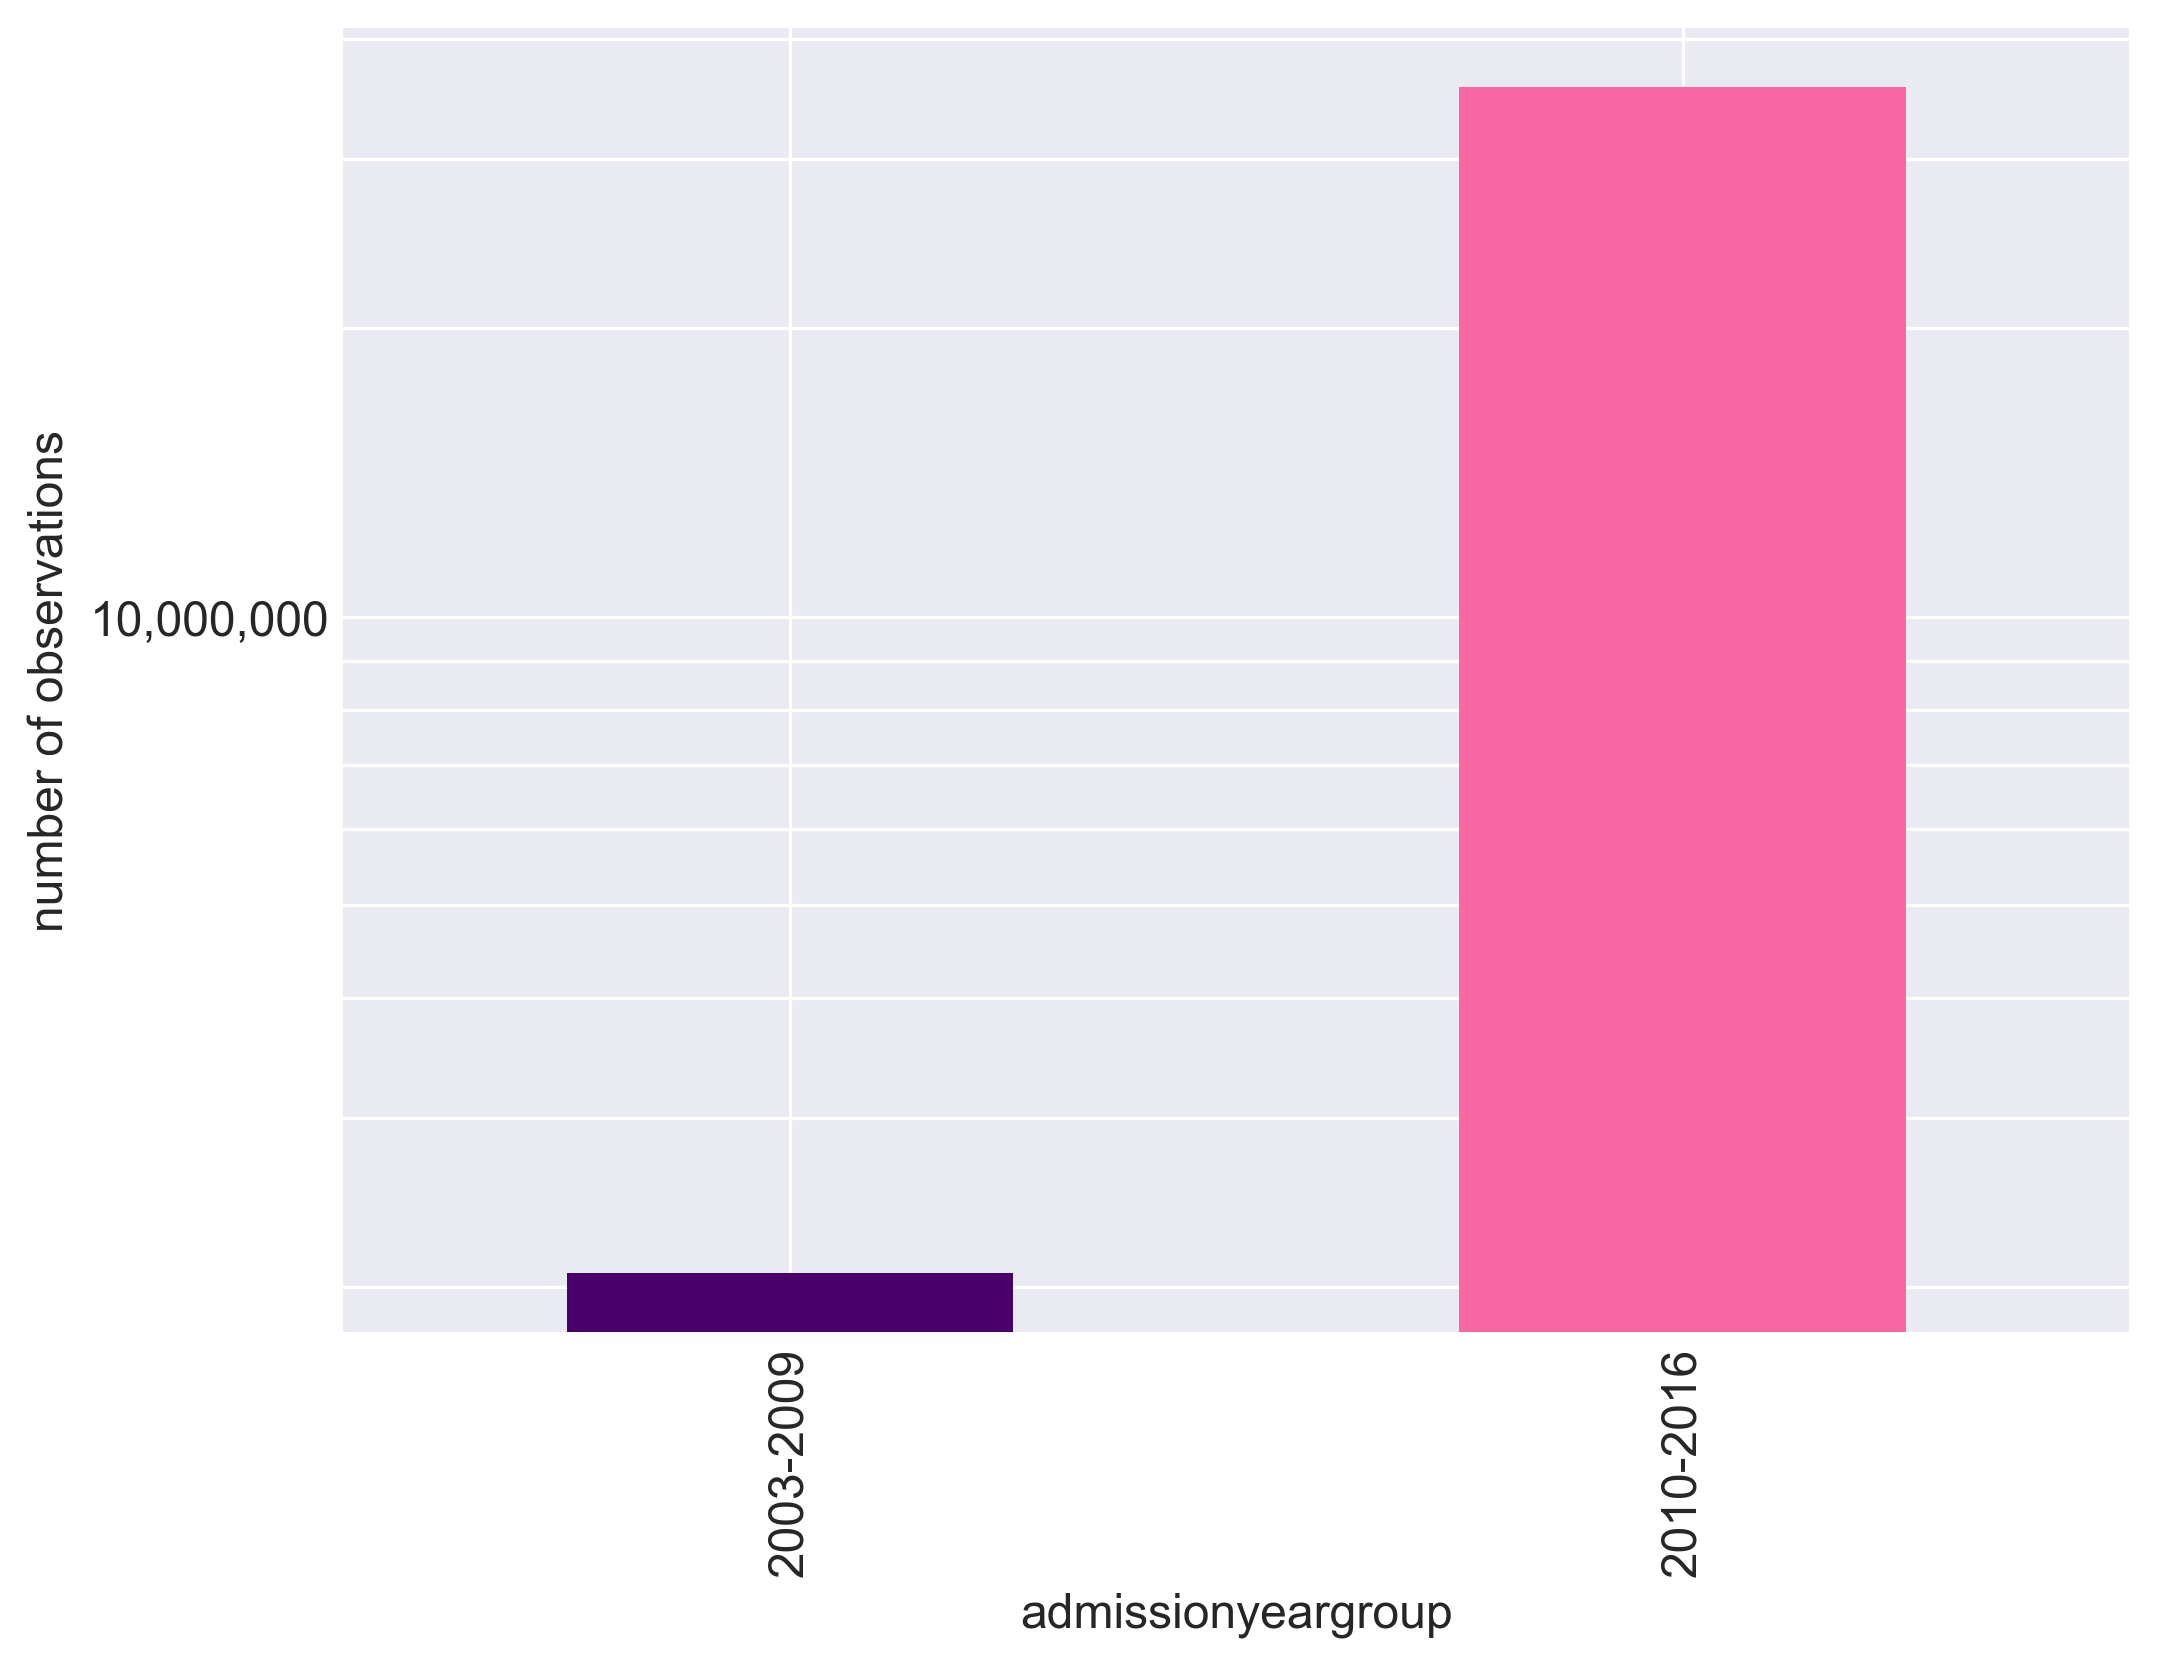

In [12]:
from matplotlib.ticker import NullFormatter  # useful for `logit` scale
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(logy=True, x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.grid('True', which='both')

## <a id='fluidout'></a>Fluidout
Fluid balance items: drains, urine catheters, renal replacement ultrafiltration

In [13]:
sql = """
SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM numericitems
WHERE fluidout > 0
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 10
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM numericitems
WHERE fluidout > 0
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 10

```

,item,number of observations,itemid
0,UrineCAD,1605278,8794
1,Thoraxdrain1 Productie,176064,8699
2,Ontlasting,98687,8789
3,CVVH Onttrokken,92260,8805
4,Ventrikeldrain1 Uit,56491,8770
5,Maaghevel,53396,8774
6,MaagRetentieWeg,29453,8777
7,Thoraxdrain2 Productie,24167,8700
8,Wonddrain1 Productie,23483,8717
9,UrineSupraPubis,15381,8796


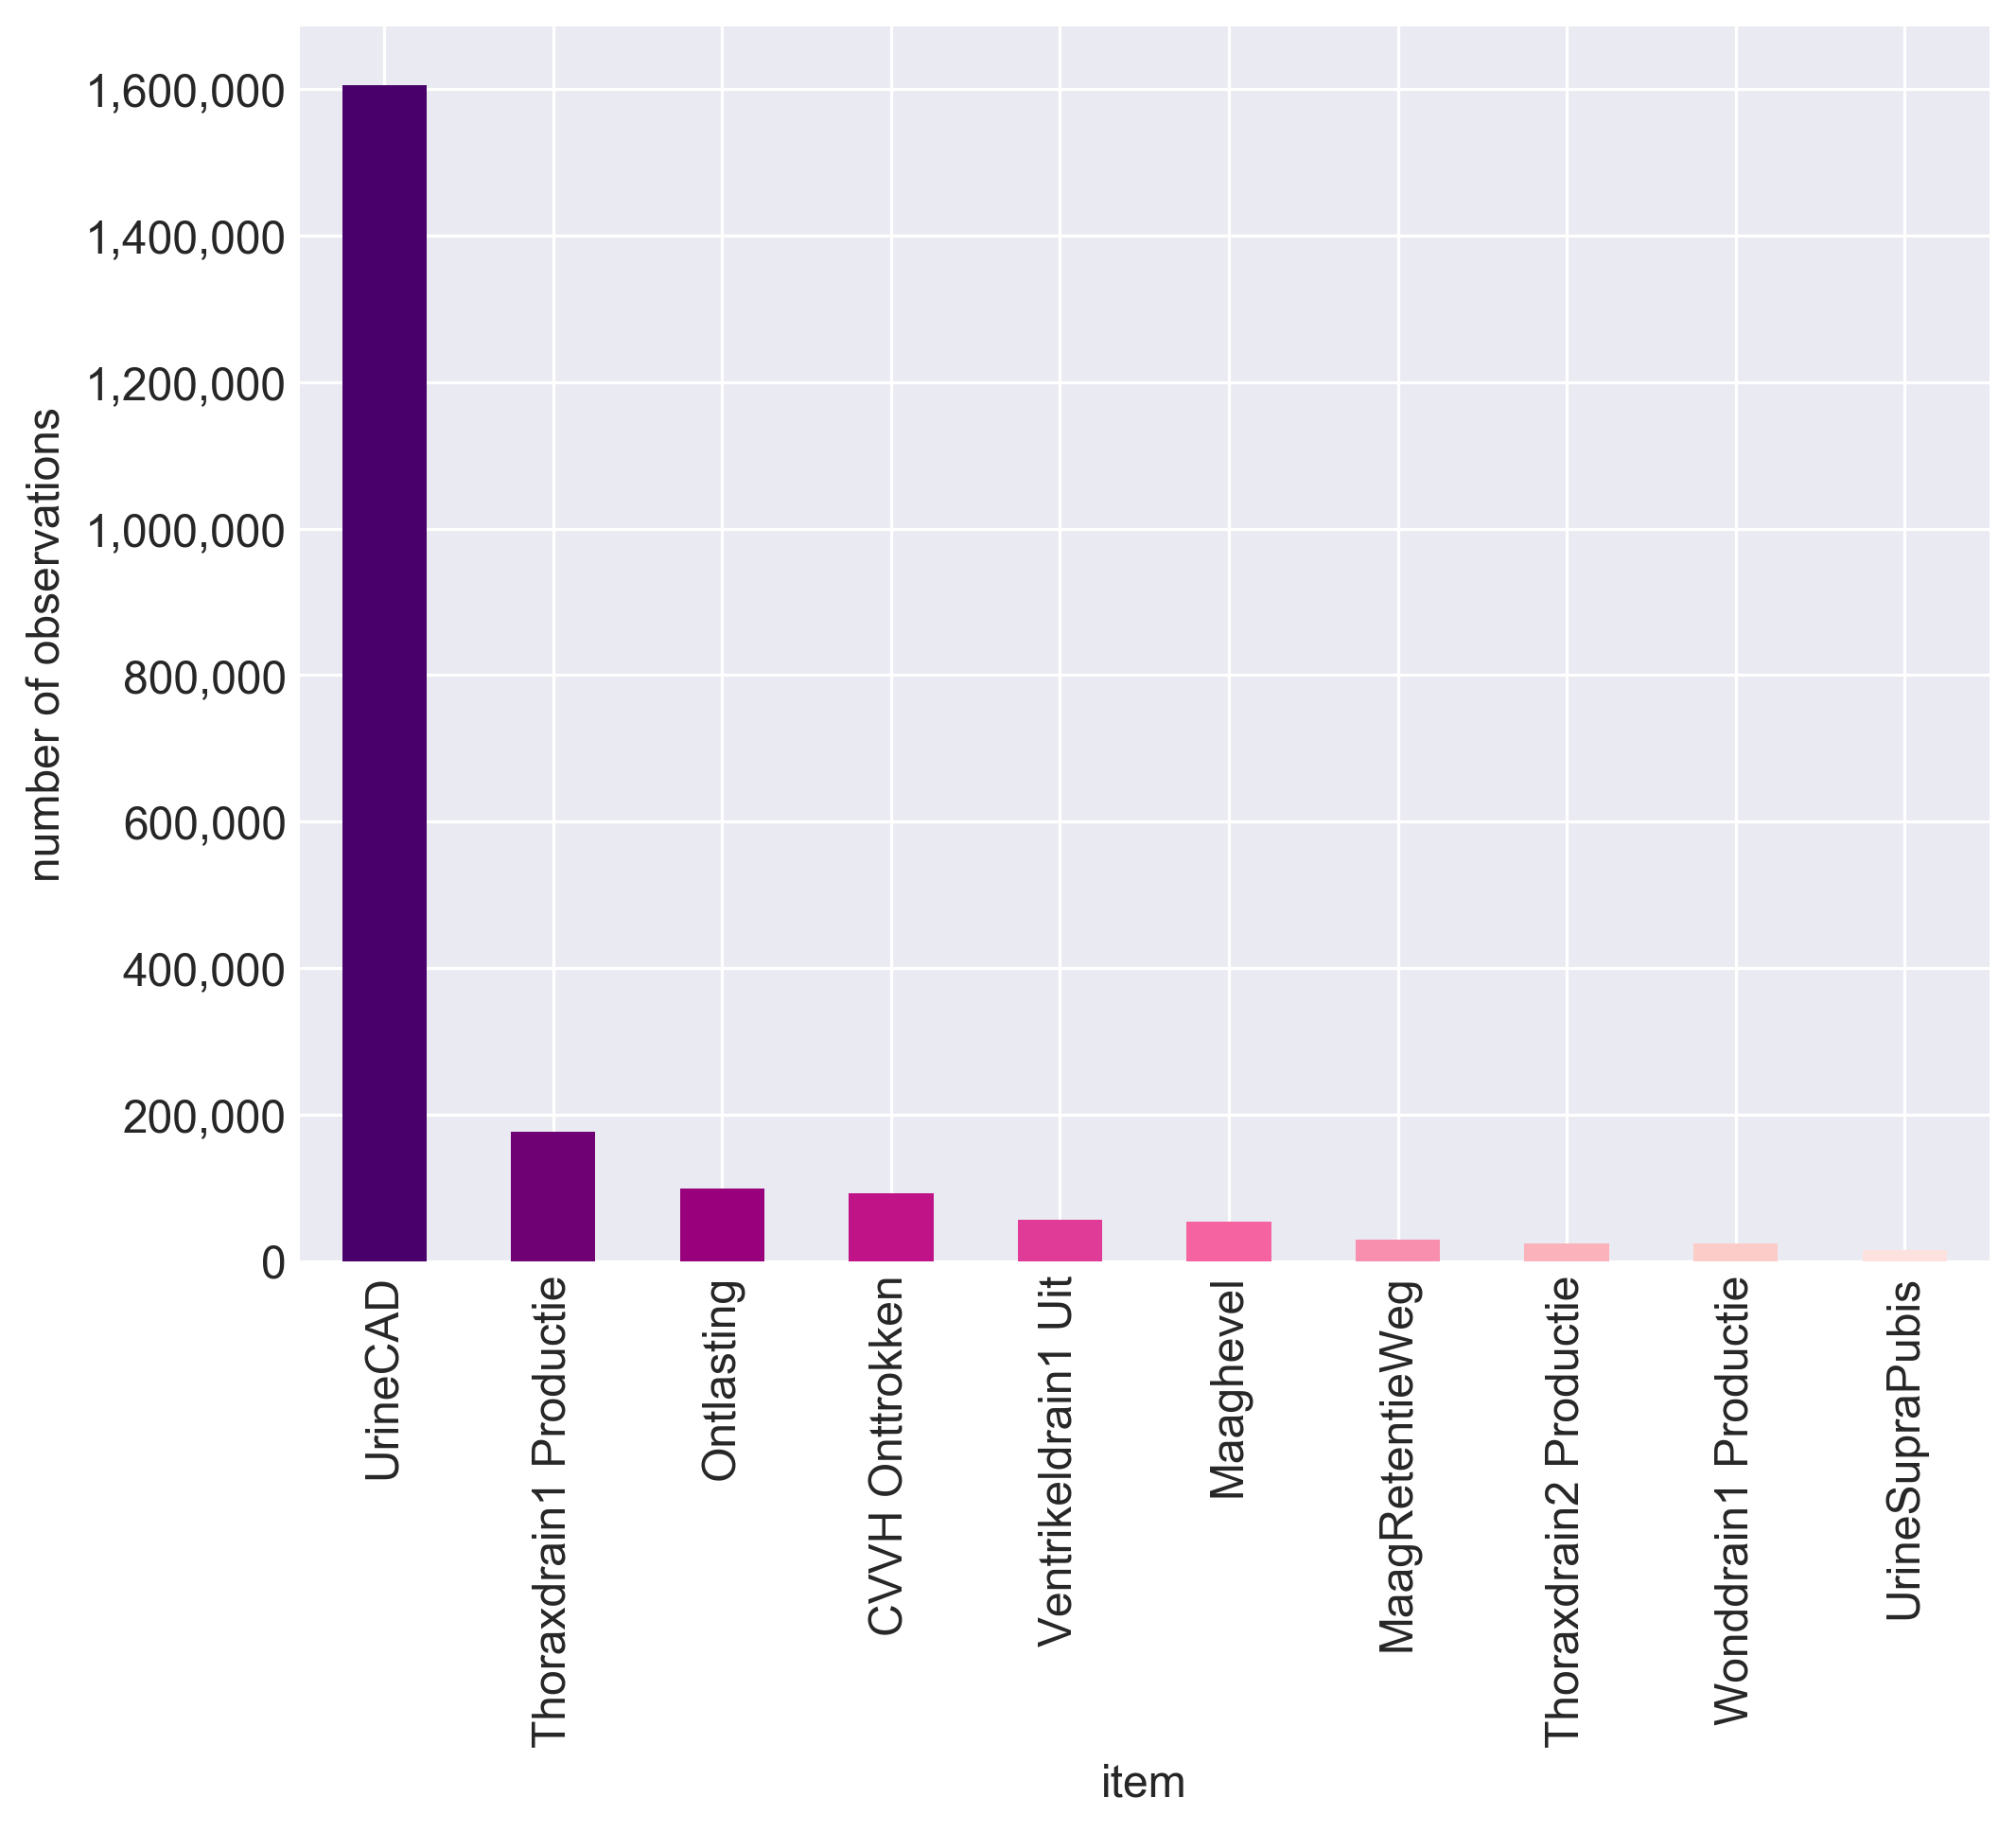

In [14]:
#plot the data
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## <a id='islabresult'></a>islabresult
Shows numeric lab results

In [15]:
sql = """
SELECT COUNT(itemid) AS "number of numeric lab results"
FROM numericitems
WHERE islabresult = B'1'
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT COUNT(itemid) AS "number of numeric lab results"
FROM numericitems
WHERE islabresult = B'1'

```

,number of numeric lab results
0,14314029


### Common lab results

In [16]:
#get the data
sql = """
SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM numericitems
WHERE islabresult = B'1'
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 20
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT item, COUNT(itemid) AS "number of observations", itemid
FROM numericitems
WHERE islabresult = B'1'
GROUP BY item, itemid
ORDER BY "number of observations" DESC
LIMIT 20

```

,item,number of observations,itemid
0,Glucose (bloed),820898,9947
1,pCO2 (bloed),659807,9990
2,pH (bloed),659777,12310
3,Act.HCO3 (bloed),657442,9992
4,B.E. (bloed),654665,9994
5,PO2 (bloed),654417,9996
6,O2-Saturatie (bloed),652901,12311
7,K (onv.ISE) (bloed),542007,10285
8,Na (onv.ISE) (bloed),527724,10284
9,Ht(v.Bgs) (bloed),494384,11545


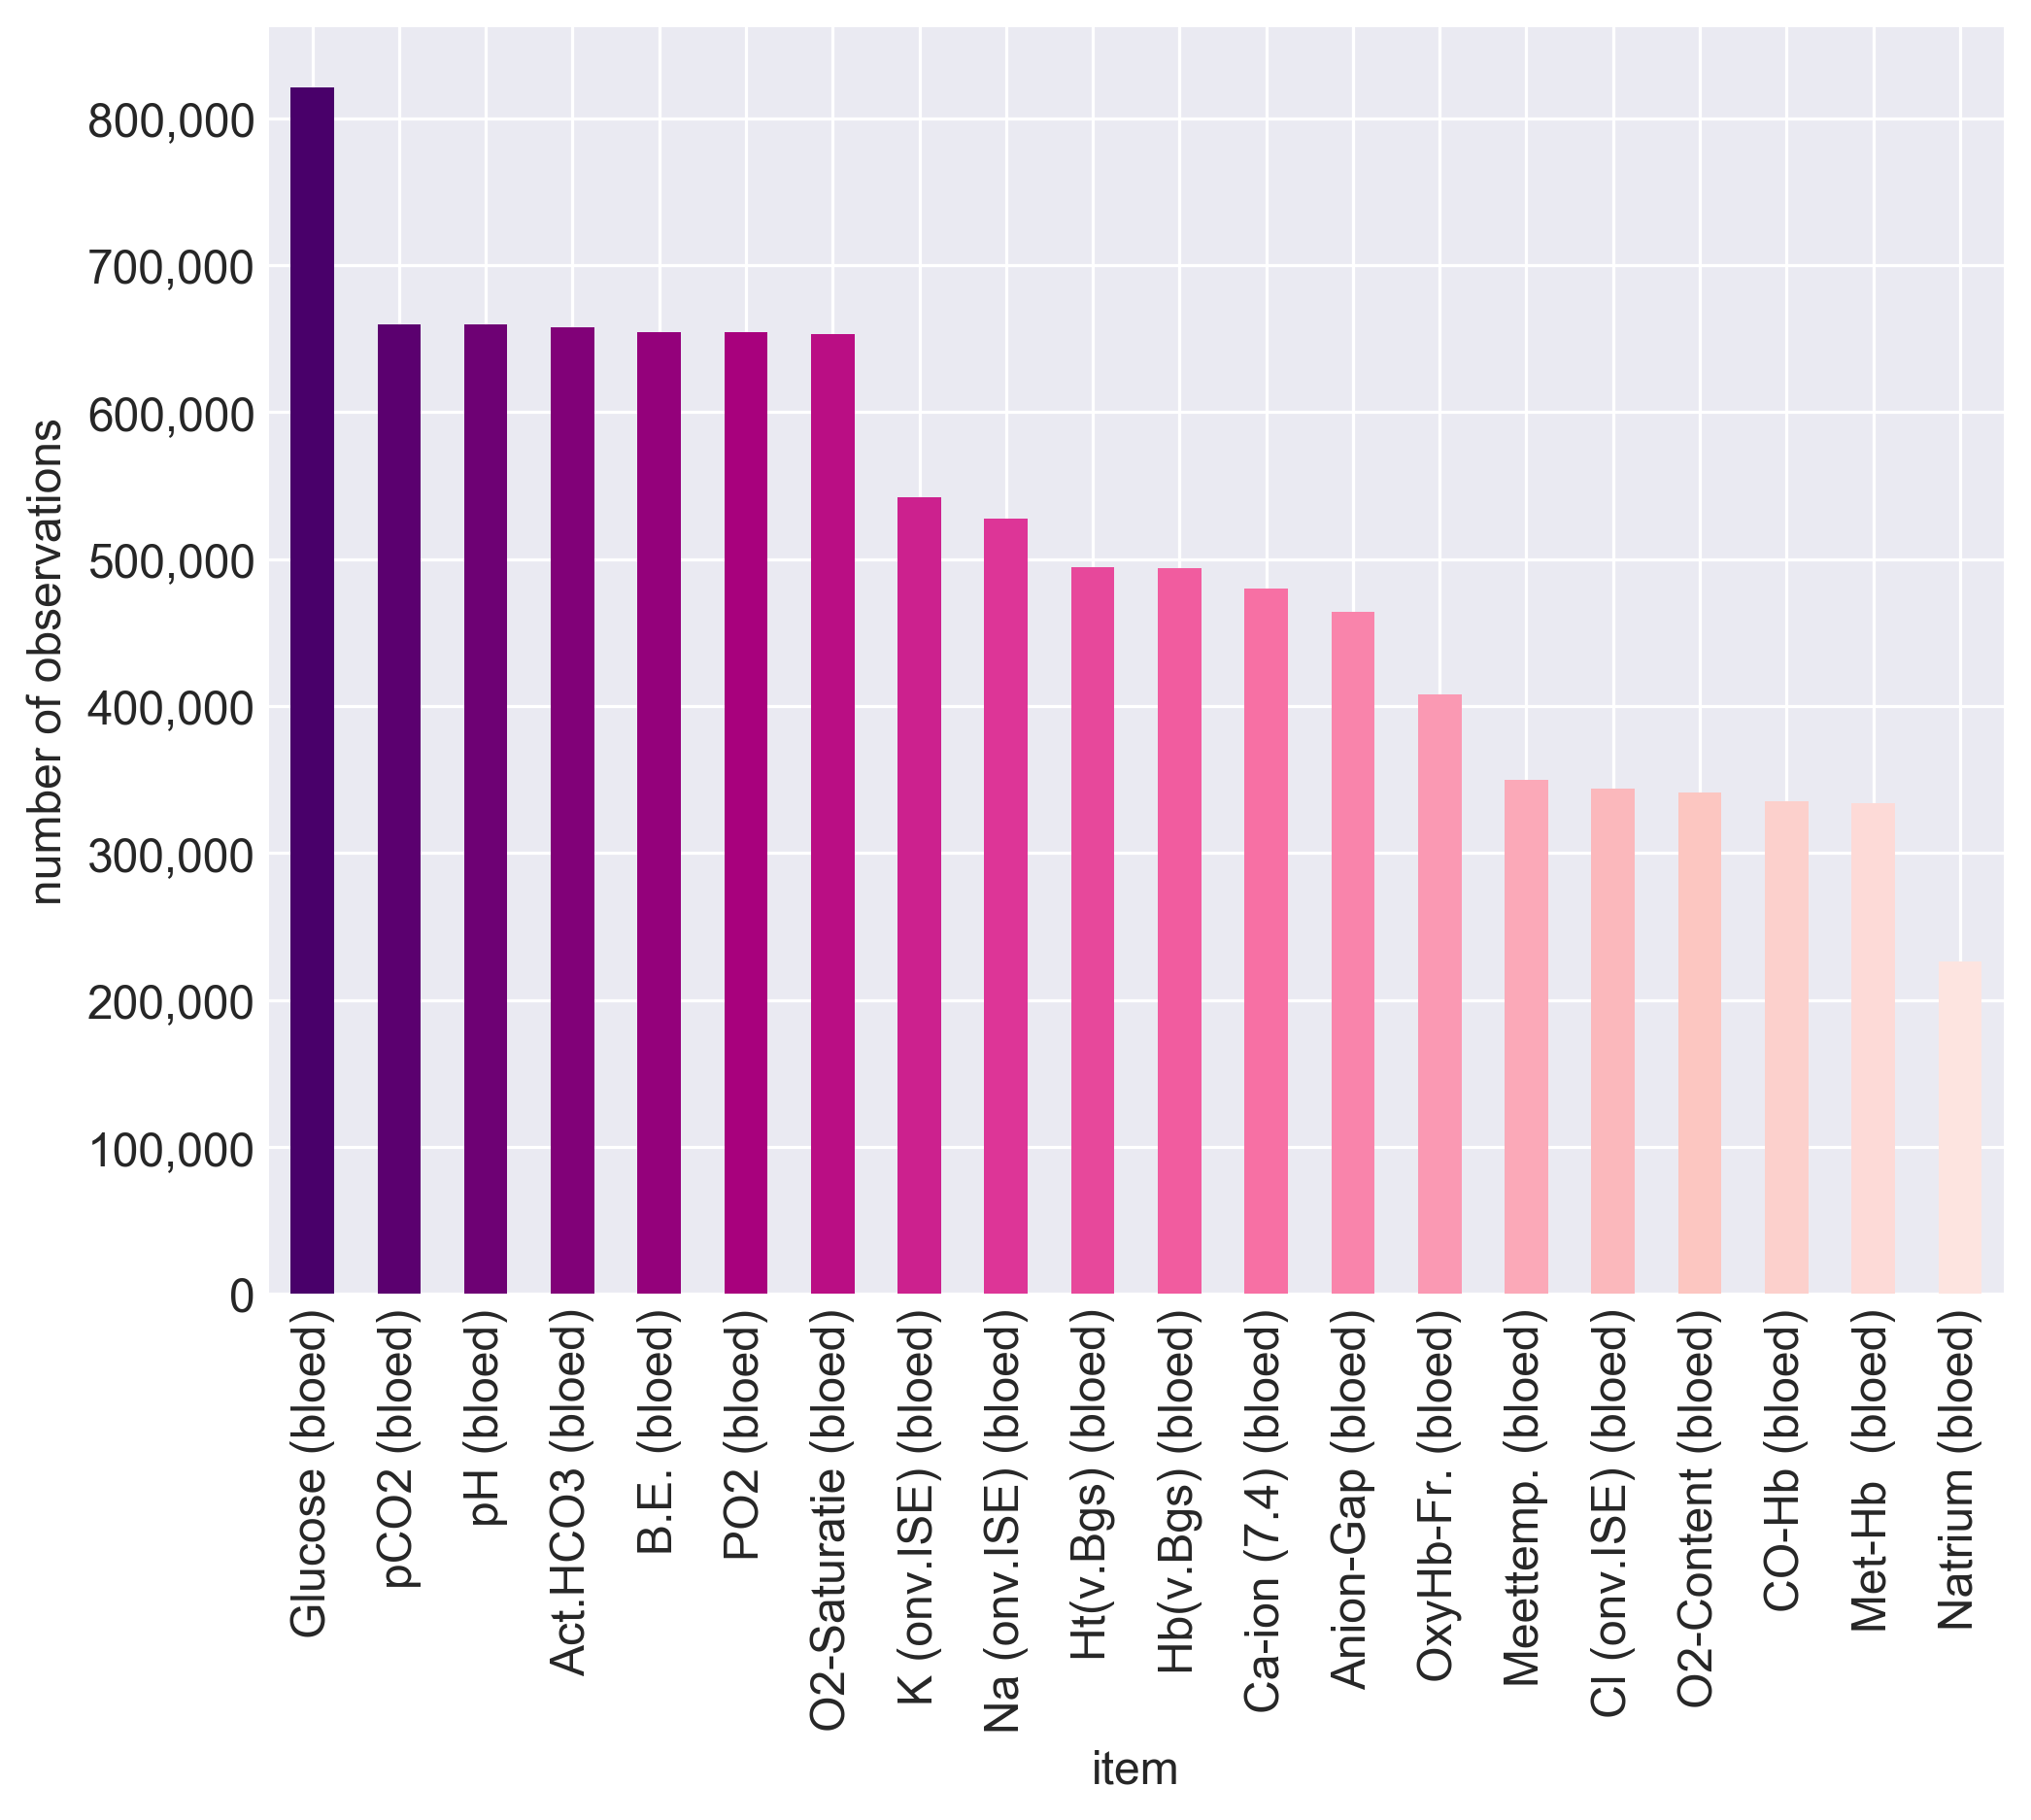

In [17]:
#plot the data
cm = plt.get_cmap('RdPu')
color_step = int(-255/len(df.index))
ax = df.plot.bar(x=df.columns[0],y=df.columns[1], legend=False,color=cm(range(255,1,color_step)))
ax.set(ylabel=df.columns[1])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

## <a id='tag'></a>Tag
Used as a 'modifier' for some lab results

In [18]:
sql = """
SELECT DISTINCT tag
FROM numericitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
df

``` mysql

SELECT DISTINCT tag
FROM numericitems

```

,tag
0,>
1,NUL
2,D
3,-
4,K
5,5
6,
7,T
8,Q
9,<


## <a id='comment'></a>comment
Mostly used for lab results for additional information

In [19]:
sql = """
SELECT DISTINCT comment
FROM numericitems
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
comments = pd.read_sql(sql,con)
comments.head()

``` mysql

SELECT DISTINCT comment
FROM numericitems

```

,comment
0,T=24 uur
1,"kb5 t124 - Indien negroide, uitslag * 1.212"
2,T=12.45
3,"korr. +, Hypersegmentatie +"
4,MIW ~


## <a id='value'></a>value
Example of plotting the values for an individual admission

In [20]:
sql = """
SELECT measuredat as time, value, item, unit, itemid 
FROM numericitems
WHERE itemid IN (
    6640, --Heart rate 
    6709, -- SpO2
    6642, -- mABP
    6641, -- sABP
    6643  -- dABP
    ) AND
    admissionid = 2
ORDER BY time
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
df = pd.read_sql(sql,con)
signals = df
signals['time'] = signals['time']/(1000*60*60)
signals.head(5)

``` mysql

SELECT measuredat as time, value, item, unit, itemid 
FROM numericitems
WHERE itemid IN (
    6640, --Heart rate 
    6709, -- SpO2 	36834293 	
    6642, -- mABP
    6641, -- sABP
    6643  -- dABP
    ) AND
    admissionid = 2
ORDER BY time

```

,time,value,item,unit,itemid
0,0.2,73.0,ABP gemiddeld,mmHg,6642
1,0.2,71.0,Hartfrequentie,/min,6640
2,0.2,55.0,ABP diastolisch,mmHg,6643
3,0.2,113.0,ABP systolisch,mmHg,6641
4,0.2,97.0,Saturatie (Monitor),None,6709


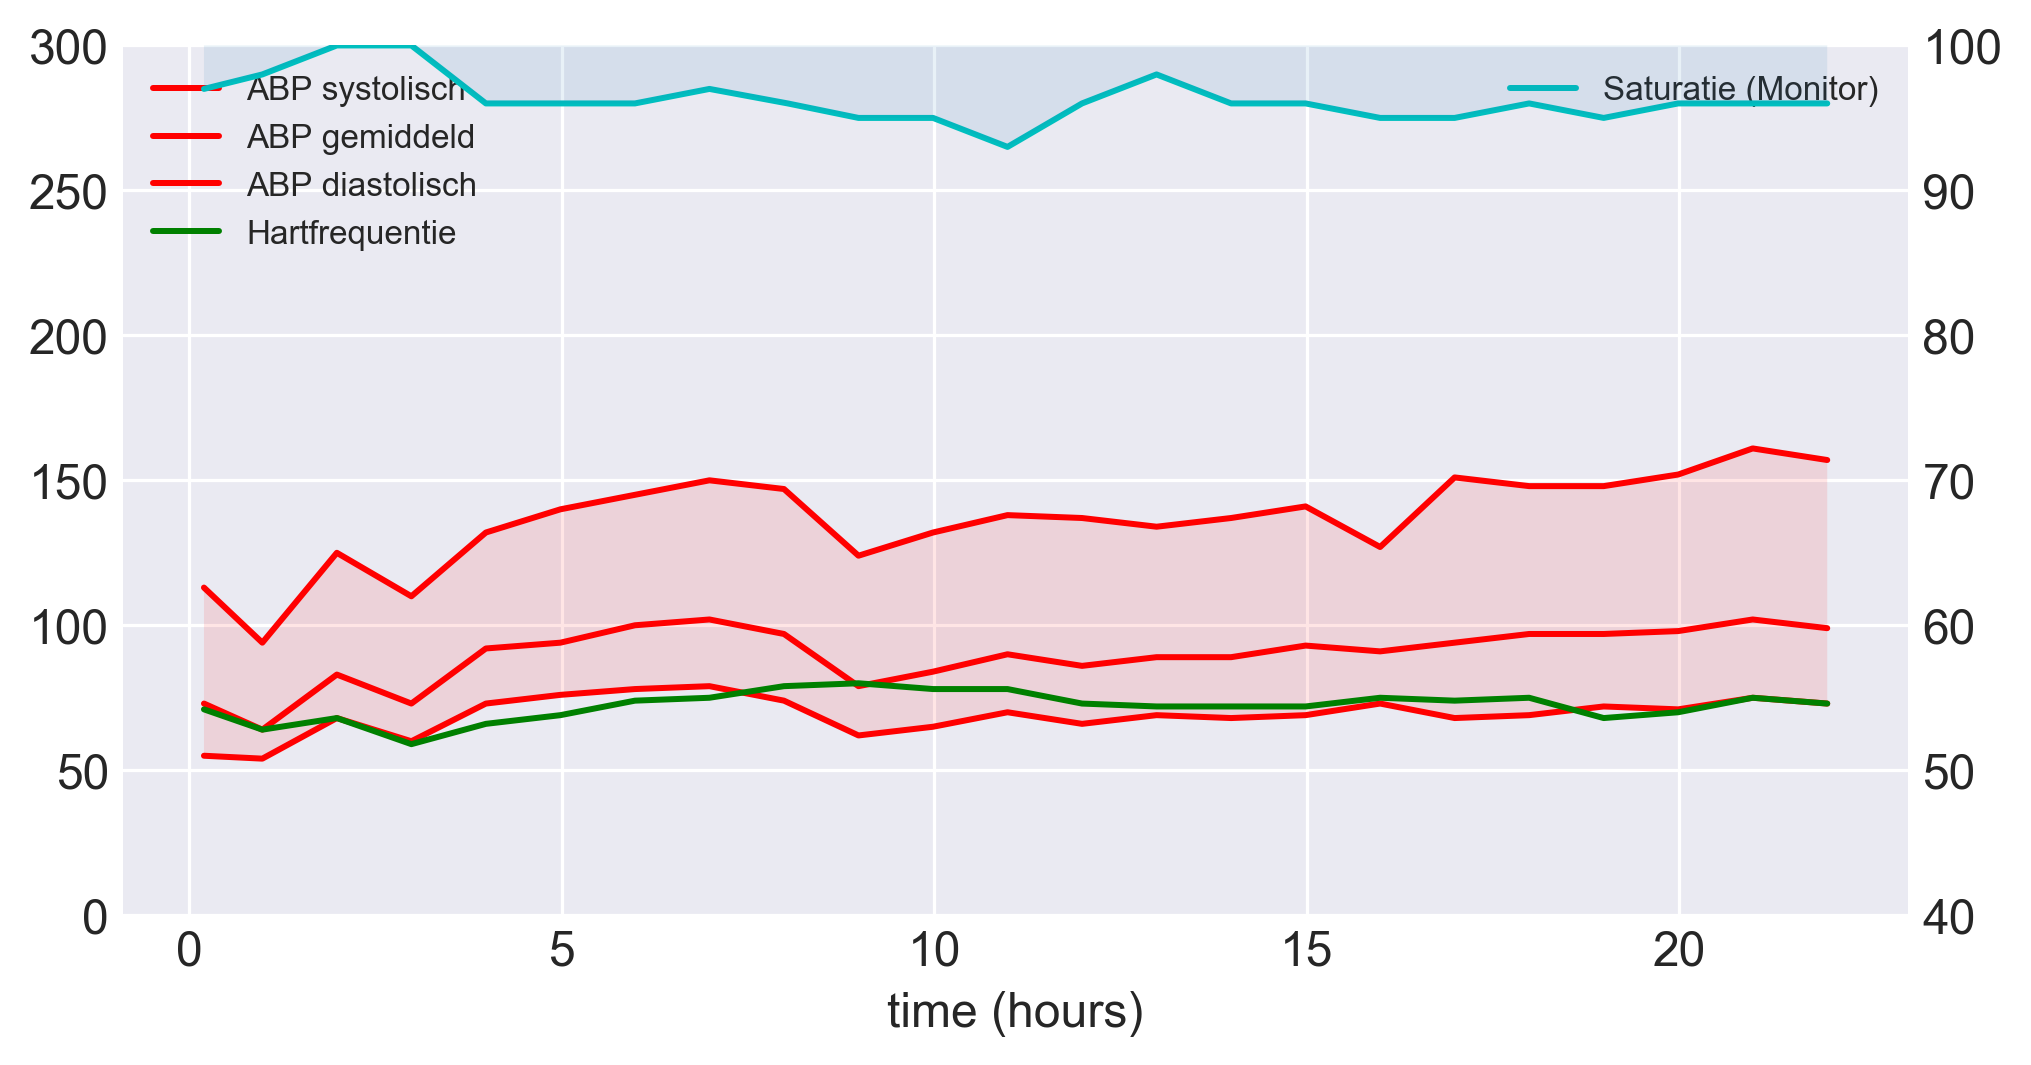

In [21]:
fig, ax1 = plt.subplots(figsize=(8, 4))

#reasonable physiological limits for axes
ax2 = ax1.twinx()  # second axis sharing x-axis for SpO2
ax1.set_ylim(top=300,bottom=0)
ax2.set_ylim(top=100,bottom=40)
ax1.set_xlabel('time (hours)')

#match scales
ylim1 = ax1.get_ylim()
len1 = ylim1[1]-ylim1[0]
yticks1 = ax1.get_yticks()
rel_dist = [(y-ylim1[0])/len1 for y in yticks1]
ylim2 = ax2.get_ylim()
len2 = ylim2[1]-ylim2[0]
yticks2 = [ry*len2+ylim2[0] for ry in rel_dist]
ax2.set_yticks(yticks2)
ax2.set_ylim(ylim2)
ax2.grid(False) #hides the unneccessary lines

ax1.set_zorder(1)
ax2.set_zorder(1)

#sbp
signal = signals[signals['itemid'] == 6641]
signal['time']
ax1.plot(signal['time'],signal['value'], 'r', label=signal['item'].iloc[0], zorder=10)

#mabp
signal = signals[signals['itemid'] == 6642]
ax1.plot(signal['time'],signal['value'], 'r', label=signal['item'].iloc[0], zorder=11)

#dabp
signal = signals[signals['itemid'] == 6643]
ax1.plot(signal['time'],signal['value'], 'r', label=signal['item'].iloc[0], zorder=12)

#fill in between
other_signal = signals[signals['itemid'] == 6641]
ax1.fill_between(signal['time'],other_signal['value'], signal['value'], facecolor='r', alpha=0.1, zorder=13)

#heart rate
signal = df[df['itemid'] == 6640]
ax1.plot(signal['time'],signal['value'], 'g', label=signal['item'].iloc[0], zorder=14)

#SpO2
signal = signals[signals['itemid'] == 6709]
ax2.plot(signal['time'],signal['value'], 'c', label=signal['item'].iloc[0], zorder=15)
ax2.fill_between(signal['time'],100, signal['value'], alpha=0.1, zorder=16)

ax1.legend(loc='upper left', fontsize = 'x-small')
ax2.legend(loc='upper right', fontsize = 'x-small')

#fig.tight_layout()

In [22]:
sql = """
SELECT admissionid,
    CASE
        WHEN destination = 'Overleden' THEN 0
        ELSE 1
    END AS aliveatdischarge,
    location,
    admissionyeargroup,
    dischargedat,
    lengthofstay,
    gender,
    agegroup,
    specialty
FROM admissions
"""
display(Markdown("``` mysql\n" + sql + "\n```"))
admissions = pd.read_sql(sql,con)

``` mysql

SELECT admissionid,
    CASE
        WHEN destination = 'Overleden' THEN 0
        ELSE 1
    END AS aliveatdischarge,
    location,
    admissionyeargroup,
    dischargedat,
    lengthofstay,
    gender,
    agegroup,
    specialty
FROM admissions

```

In [23]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy
import scipy.signal
from matplotlib import colors
from ipywidgets import widgets
from ipywidgets import interact

import random

def geticuview(id, smooth=False):
    
    try:
    
        sql = (
        """
        SELECT measuredat as time, value, item, unit, itemid 
        FROM numericitems
        WHERE itemid IN (
            6640, --Heart rate 
            6709, -- SpO2
            6642, -- mABP
            6641, -- sABP
            6643  -- dABP
            ) 
        """ + 
        "AND admissionid = " + str(id) +
        """
        ORDER BY time
        """)

        signals = pd.read_sql(sql,con)
        signals['time'] = signals['time']/(1000*60*60)   

        #create figure with secondary y-axis
        fig = make_subplots(specs=[[{"secondary_y": True}]])
        fig.layout.yaxis2.range = [40,100]

        #SpO2
        signalids = [
            ##itemid, color, fill, secondary
            (6709, 'cyan', 'tonexty', True), #SpO2
            (6643, 'red', None, False), #diastolic abp
            (6641, 'red', 'tonexty', False), #systolic abp
            (6642, 'red', None, False),#mean abp
            (6640, 'green', None, False) #heart rate
        ]

        #100% line:
        s = signalids[0]
        color = colors.to_rgba(s[1])
        #change alpha channel of the color tuple
        red = color[0]
        green = color[1]
        blue = color[2]
        alpha = 0.2
        fillcolor = 'rgba('+ str(red*255) + ',' + str(green*255) + ',' + str(blue*255) + ',' + str(alpha) + ')'

        signal = signals[signals['itemid'] == s[0]]
        fig.add_trace(
            go.Scatter(
                x=signal['time'], 
                y= np.full((len(signal['time'])), 100), #use 100% as mark
                mode='lines',
                name=None,
                showlegend=False,
                line_color=fillcolor,
                fill=None,
                fillcolor=None,
                hoverinfo='none' #disable hovering for reference line
            ),
            secondary_y=s[3]
        )

        for s in signalids:
            color = colors.to_rgba(s[1])
            #change alpha channel of the color tuple
            red = color[0]
            green = color[1]
            blue = color[2]
            alpha = 0.2
            fillcolor = 'rgba('+ str(red*255) + ',' + str(green*255) + ',' + str(blue*255) + ',' + str(alpha) + ')'

            #smoothing settings for SciPy's Savgol Filter 
            windowsize = int(len(signal['value'])/10)
            if windowsize > int(len(signal['value'])/10):
                windowsize = len(signal['value'])
            if windowsize%2==0: 
                windowsize += 1
            if windowsize < 4: 
                windowsize = 3           
            polyorder = 5
            
            signal = signals[signals['itemid'] == s[0]]
            fig.add_trace(
                go.Scatter(
                    x=signal['time'], 
                    y=(scipy.signal.savgol_filter(signal['value'],
                           windowsize, # window size used for filtering
                           polyorder) # order of fitted polynomial)
                       if smooth 
                       else 
                           signal['value']
                      ),
                    mode='lines',
                    name=signal['item'].iloc[0],
                    line_color=s[1],
                    fill=s[2],
                    fillcolor=fillcolor
                ),
                secondary_y=s[3]
            )
        return fig
    except Exception as e:
        print(e)

def validate():
    if admissions_slider.value in admissions['admissionid'].unique():
        return True
    else:
        return False
    
def updateicuview(change):
    if validate():
        print(change.new)
        
            
def requery(change):
    selection = admissions[(admissions['aliveatdischarge'] == alive_checkbox.value) &
                           (admissions['agegroup'] == agegroup_dropdown.value) &
                           (admissions['admissionyeargroup'] == admissionyeargroup_dropdown.value)
                          ]
    admissions_slider.options = selection['admissionid'].unique().tolist()
    #admissions_slider.value = random.choice(selection['admissionid'].unique().tolist())
    
def response(change):
    smooth_curves.value = False
    fig = geticuview(admissions_slider.value, smooth_curves.value)
    if fig is not None:
        with figurewidget.batch_update():
            figurewidget.layout.title = admissions_slider.value
            for i in range(len(figurewidget.data)):
                figurewidget.data[i].x =  fig.data[i].x
                figurewidget.data[i].y =  fig.data[i].y

def toggle_smooth(change):
    fig = geticuview(admissions_slider.value, smooth_curves.value)
    if fig is not None:
        with figurewidget.batch_update():
            saved_range = figurewidget.layout.yaxis1.range
            figurewidget.layout.title = admissions_slider.value
            for i in range(len(figurewidget.data)):
                figurewidget.data[i].x =  fig.data[i].x
                figurewidget.data[i].y =  fig.data[i].y
            figurewidget.layout.yaxis1.range = saved_range

alive_checkbox = widgets.Checkbox(
    description='Alive at discharge',
    value=True,
)

admissions_slider = widgets.SelectionSlider(
    options=admissions['admissionid'].unique().tolist(),
    value=admissions['admissionid'].unique().tolist()[0],
    description='Admissionid:',
    continuous_update=False
)

agegroup_dropdown = widgets.Dropdown(
    options=admissions['agegroup'].sort_values().unique().tolist(),
    value=admissions['agegroup'].sort_values().unique().tolist()[0],
    description='Age:',
    disabled=False,
)

admissionyeargroup_dropdown = widgets.Dropdown(
    options=admissions['admissionyeargroup'].sort_values().unique().tolist(),
    value=admissions['admissionyeargroup'].sort_values().unique().tolist()[0],
    description='Admission year:',
    disabled=False,
)

smooth_curves = widgets.Checkbox(
    description='Smooth curves',
    value=False,
)
               
fig = geticuview(admissions_slider.value, smooth=False)
figurewidget = go.FigureWidget(fig)

alive_checkbox.observe(requery, names='value')
admissionyeargroup_dropdown.observe(requery, names='value')
agegroup_dropdown.observe(requery, names='value')
smooth_curves.observe(toggle_smooth, names='value')
admissions_slider.observe(response, names= 'value')

container1 = widgets.VBox([agegroup_dropdown, admissionyeargroup_dropdown])
container2 = widgets.VBox([alive_checkbox])

display(widgets.VBox([admissions_slider]))
display(widgets.VBox([container1,container2]))
display(widgets.VBox([figurewidget, smooth_curves]))


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgba(0.0,255…